Цель:
Изучить применение моделей кластеризации
В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import cv2
import skimage

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

from skimage.metrics import structural_similarity #ssim

Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).
a) Для отображения картинки воспользуйтесь вспомогательной функцией:

In [ ]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

b) Для загрузки картинки можно использовать код:

--2023-02-20 07:55:40--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2023-02-20 07:55:40--  http://img.jpg/
Resolving img.jpg (img.jpg)... failed: Name or service not known.
wget: unable to resolve host address ‘img.jpg’
--2023-02-20 07:55:40--  https://drive.google.com/uc?id=1Vs-MsmsXS4zU7lng4guFv4j2D4EkDOvp
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.101, 74.125.195.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jt64gkv9k1073tq535i5n2moahvurjnk/1676879700000/04873730849060548813/*/1Vs-MsmsXS4zU7lng4guFv4j2D4EkDOvp?uuid=a9b6c207-2c1e-48da-a0fe-d580d8b769d6 [following]
--2023-02-20 07:55:40--  https://doc-0s-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jt64gkv9k1

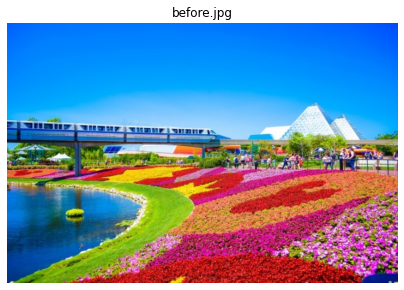

In [ ]:
# path = '/content/1.jpg' #(466, 700, 3)
# # path = '/content/ball1.jpg' #(850, 1332, 3)
# # path = '/content/rain1.jpg'  #(480, 852, 3)

# # im = im.crop((1, 1, 98, 33))
# img = cv2.imread(path)
!wget -r - img.jpg "https://drive.google.com/uc?id=1Vs-MsmsXS4zU7lng4guFv4j2D4EkDOvp"
img = cv2.imread("/content/drive.google.com/uc?id=1Vs-MsmsXS4zU7lng4guFv4j2D4EkDOvp")
# cropped_image=img[350:500, 200:400]
# draw_picture(cropped_image,'before.jpg')
# img = cropped_image
jpg_before = img
# cropped_image.shape

# img = img.reshape(233,350,3)
draw_picture(img,'before.jpg')

In [ ]:
# draw_picture(cropped_image,'before.jpg')
# img = cropped_image
# jpg_before = img

In [ ]:
img.shape

(466, 700, 3)

In [ ]:
d_ssim = {}
n_i,n_j,n_color = img.shape
# img_train = img.reshape((n_i,n_j*n_color))
# переведу каждый пиксель в строку ргб
# так я сохраню значение каждого пикселя
# в предыдущем случае так и не поняла как его вытащить(
    
img_train = img.reshape(n_i*n_j,n_color)
img_train.shape

(326200, 3)

In [ ]:
 #  на img_train Я ПОСЛЕДНИЙ РАЗ ВИЖУ ЦВЕТА!!!
# выполним понижение размерности
# для рисования больше
X = img_train
dim = 2
pca = PCA(n_components=dim)
X_red = pca.fit_transform(X)

используемые функции:

In [ ]:
# найду центроид для каждого кластера
def centr_i(X, centr_1):
  # поиск строки, ближайшей к центроиду
  min_d = 1000
  min_i = -1
  for i in range(len(X)):
    X_i = X[i]
    tmp_d =   np.sqrt((X_i[0] - centr_1[0])**2 + (X_i[1] - centr_1[1])**2)
    if tmp_d < min_d:
      min_d = tmp_d
      min_i = i
  return min_i
def centr_s(X, centrs):
  # номера строк для всех кластеров
  res = []
  for centr_1 in centrs:
    res.append(centr_i(X,centr_1))
  return res

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()  

2. Реализуйте три модели кластеризации:
a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [ ]:

# from skimage.measure import compare_ssim



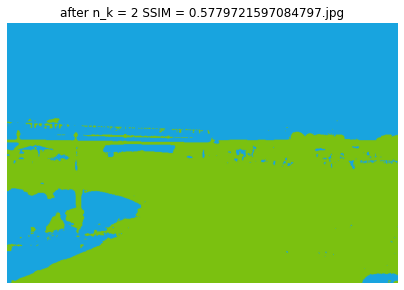

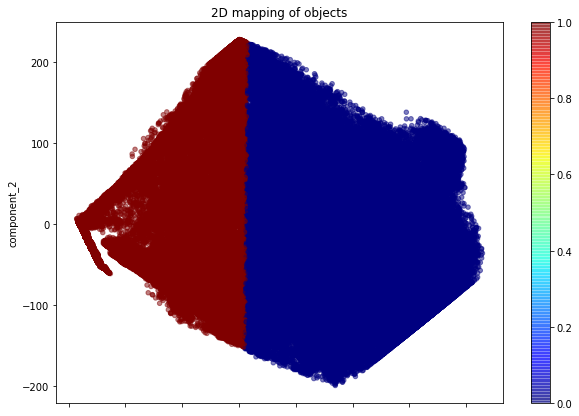

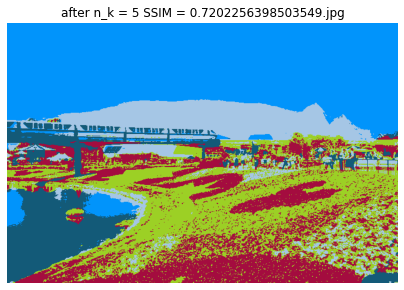

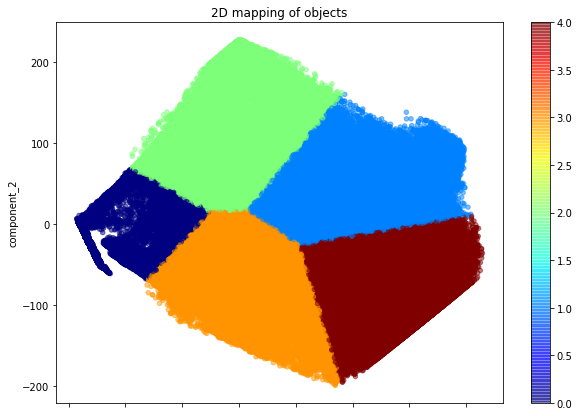

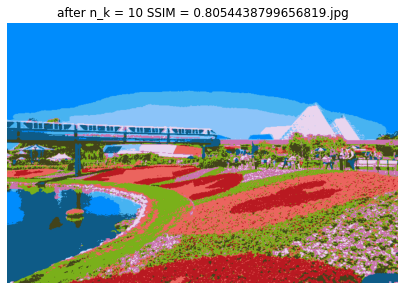

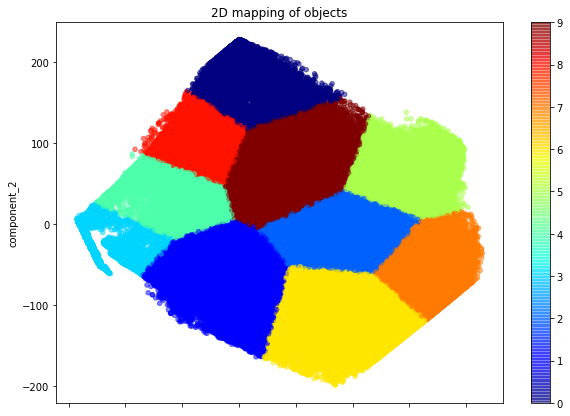

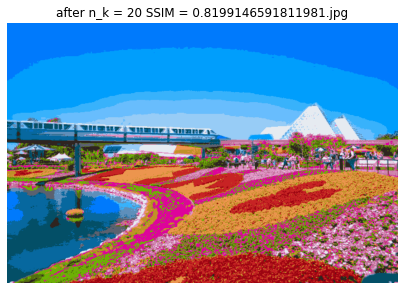

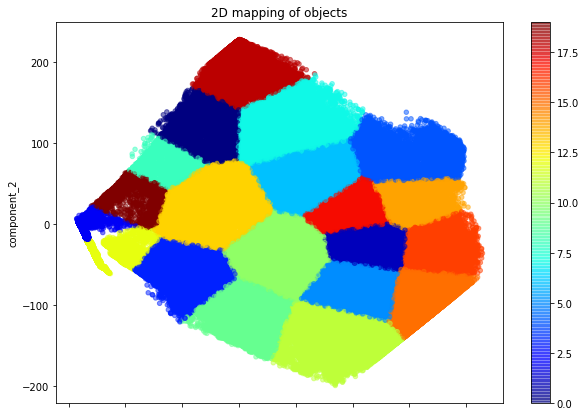

In [ ]:
n_k_list = [2,5,10,20]
for n_k in n_k_list:
  X = X_red.copy()
  X_rgb = img_train.copy()
  # scaler = StandardScaler()
  # X_scaled = scaler.fit_transform(X)

  alg_kmeans = KMeans(n_clusters=n_k)
  clusters = alg_kmeans.fit_predict(X)
  centr = alg_kmeans.cluster_centers_
  # ближайшие к центру точки
  i_d = centr_s(X, centr)

  #  После выделения кластеров все пиксели, 
  # отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.
  i = 0
  for c in np.unique(clusters):
    clust_color = X_rgb[i_d[i]]
    X_rgb[clusters == c] = clust_color
    i+=1
  # теперь решейпну в картинку обратно
  X_after = X_rgb.reshape(n_i,n_j,n_color)
  jpg_after = X_after
  (score, diff) = structural_similarity(jpg_before, jpg_after, win_size=3, full=True)
  diff = (diff * 255).astype("uint8")
  d_ssim['k_means '+str(f'nk = {n_k}')] = score
  draw_picture(jpg_after,f'after n_k = {n_k} SSIM = {score}.jpg')


# print("k_n:{}SSIM:{}".format(n_k,score))

  # теперь надо нарисовать кластеры
  colnames = ['component_' + str(i) for i in range(1, dim+1)]

  X_2 = pd.DataFrame(X,columns=colnames)
  # рисую в 2 компоненты



  # labels_clast = alg_kmeans.fit_predict(X)
  labels_clast = pd.Series(clusters, name='clusters')
  display_components_in_2D_space(X_2,labels=labels_clast)

In [ ]:
# type(centr),type(X[0])
# centr8 = np.uint8(centr) 156 2-10
# 2.5 - 5 = er
# 3-5 = er
# 2-5 = 63
# 1.5 - 7 = 625

In [ ]:
l = [1,1,2,3,4]


b) DBSCAN

In [ ]:
X_r = X_red.copy()
scaler = StandardScaler()
X = scaler.fit_transform(X_r)
X_rgb = img_train.copy()
X_s = X.copy
dbscan = DBSCAN(eps=0.03).fit(X) #2-5 eps=2, min_samples=5
clusters_db = dbscan.labels_
print(len(np.unique(clusters_db)))
print('-----------')
unique, counts = np.unique(clusters_db, return_counts=True)
dict(zip(unique, counts))
# саммая странное в этой работе:

In [ ]:
X = X_red.copy()
X_rgb = img_train.copy()
for c in np.unique(clusters_db):
  # центр каждого кластера        centoid_0 = np.mean(X_scaled[preds == 0], axis=0)
  centoid_c = np.mean(X[clusters_db == c], axis=0)
  # ближайшая точка к центру: (строка)
  i_c = centr_i(X, centoid_c)
  clust_color = X_rgb[i_c]
  X_rgb[clusters_db == c] = clust_color
  # print(centoid_i)
  # print(clust_color)


In [ ]:
# X_rgb.shape, X_after.shape, n_i,n_j,n_color, jpg_before.shape
# -1  676 ,при 2-5 ssim = 0.113
#     7854 = 2.5% при 1.5 - 7 ssim = 0.09
len(X_rgb[clusters_db == -1])

In [ ]:

# теперь решейпну в картинку обратно
X_after = X_rgb.reshape(n_i,n_j,n_color)
jpg_after = X_after
(score, diff) = structural_similarity(jpg_before, jpg_after, win_size=3, full=True)
# diff = (diff * 255).astype("uint8")
d_ssim['dbscan n_k =' + str(f'{len(np.unique(clusters_db))}')] = score
draw_picture(X_after,f'after n_k = {len(np.unique(clusters_db))} SSIM = {score}.jpg')

# теперь надо нарисовать кластеры
colnames = ['component_' + str(i) for i in range(1, dim+1)]

X_2 = pd.DataFrame(X,columns=colnames)
  # рисую в 2 компоненты



  # labels_clast = alg_kmeans.fit_predict(X)
labels_clast = pd.Series(clusters_db, name='clusters')
display_components_in_2D_space(X_2,labels=labels_clast)


In [ ]:
len(X_rgb[clusters_db == -1])

In [ ]:
len(np.unique(clusters_db))

c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.

In [ ]:
for n_k in [2,5,10,20]:
    aggl = AgglomerativeClustering(n_clusters=n_k)
    clusters_aggl = aggl.fit_predict(X)
    print(len(np.unique(clusters_aggl)))
    X = X_red.copy()
    X_rgb = img_train.copy()
    for c in np.unique(clusters_aggl):
      # центр каждого кластера        centoid_0 = np.mean(X_scaled[preds == 0], axis=0)
      centoid_c = np.mean(X[clusters_aggl == c], axis=0)
      # ближайшая точка к центру: (строка)
      i_c = centr_i(X, centoid_c)
      clust_color = X_rgb[i_c]
      X_rgb[clusters_aggl == c] = clust_color
      # print(centoid_i)
      # print(clust_color)

    # теперь решейпну в картинку обратно
    X_after = X_rgb.reshape(n_i,n_j,n_color)
    jpg_after = X_after
    (score, diff) = structural_similarity(jpg_before, jpg_after, win_size=3, full=True)
    # diff = (diff * 255).astype("uint8")
    d_ssim['agglg '+str(f'nk = {n_k}')] = score
    draw_picture(X_after,f'after n_k = {len(np.unique(clusters_aggl))} SSIM = {score}.jpg')

    # теперь надо нарисовать кластеры
    colnames = ['component_' + str(i) for i in range(1, dim+1)]

    X_2 = pd.DataFrame(X,columns=colnames)
      # рисую в 2 компоненты



      # labels_clast = alg_kmeans.fit_predict(X)
    labels_clast = pd.Series(clusters_aggl, name='clusters')
    display_components_in_2D_space(X_2,labels=labels_clast)



3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.

In [ ]:
# df_ssim = pd.DataFrame.from_dict(d_ssim)
df = pd.DataFrame.from_dict(d_ssim, orient='index')
df.sort_values(0,ascending=True)

4. Сформулируйте выводы по проделанной работе.
a) Какая модель показала лучший результат?

In [ ]:
"""
dbscan и AgglomerativeClustering казалось невозможным исполнить на оперативке колаба.
пришлось уменьшить   изображение
по метрике ssim лучший результат показала AgglomerativeClustering на 20 кластерах

очень странно что dbscan хоть и разделил на 23 класса почти все значения положил в класс 0.
тем самым разделение сработало ужасно.
какие только я не пыталась подобрать параметры - лучше не стало.


"""